In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy

     |████████████████████████████████| 2.0 MB 7.0 MB/s 
     |████████████████████████████████| 91 kB 11.6 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=9e7c345e43b76b1d1ed1649185cc0dfa4dd41c2c4858b14835ea04a78e2cb51e
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=1bf62ac6573e744cb09d82955c886cf36cdc78a7ec6602b566127be83ff448af
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=793e751f16925fa3c03715cd5c1daf4737f2e4f94f2d09851c9918c2c7d6d102
  Stored in directory: /root/.cache/p

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import anndata as ad
import seaborn as sns
from collections import Counter
import scipy.io
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import pylab

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics

import os

import re
import gc


sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=250) #INCREASE LATER!


pylab.rcParams['figure.figsize'] = (7, 4.5)

In [ ]:
%cd /content/drive/MyDrive/MBA/
%ls

/content/drive/MyDrive/MBA
cache/        Notebooks/           pancreas_raw.h5ad  SVMrej_metricas1.csv
Data/         pancreas_ct1.csv     SVM_metricas1.csv  SVMrej_metricas2.csv
Diabetes/     pancreas_ct1.gsheet  SVM_metricas2.csv  SVMrej_metricas3.csv
Disciplinas/  pancreas.h5ad        SVM_metricas3.csv


# Loading Data

In [ ]:
adata = sc.read_h5ad("pancreas.h5ad")
print(adata.obs.Celltype.unique())
adata

['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']
Categories (7, object): ['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']


AnnData object with n_obs × n_vars = 26091 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
h = ["H1", "H2", "H3", "H4", "H5", "H6"]
d = ["T2D1", "T2D2", "T2D3"]

## Modelo 1: Treino H, Teste H

In [ ]:
dados1 = adata[adata.obs.Donor.isin(h)].copy()
dados1

AnnData object with n_obs × n_vars = 20474 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
classes = list(dados1.obs.Celltype.unique())
classes.sort()

Classifier1 = []
data1 = []

predicted1 = []
acc1 = []
f1_sep1 = []
f1_all1 = []

In [ ]:
for k in range(5):

  # Separação dos dados
  X_train1, X_test1, y_train1, y_test1 = train_test_split(dados1.X, dados1.obs.Celltype, test_size=0.2, random_state=k, stratify=dados1.obs.Celltype)
  data1.append((X_train1, X_test1, y_train1, y_test1))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in y_train1 if j==i]))
      test.append(len([j for j in y_test1 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Treinamento
  Classifier1.append(LinearSVC(max_iter=5000))
  Classifier1[-1].fit(X_train1, y_train1)

  # Teste
  predicted1.append(Classifier1[-1].predict(X_test1))

  ### Avaliação do modelo
  # Acurácia
  acc1.append(Classifier1[-1].score(X_test1, y_test1))
  # F1
  f1_sep1.append(metrics.f1_score(y_test1, predicted1[-1], average=None))
  f1_all1.append(metrics.f1_score(y_test1, predicted1[-1], average="macro"))


,Train,Test
Acinar,54,13
Alpha,7748,1937
Beta,6245,1562
delta,389,97
duct,742,186
pp,450,112
psc,751,188


In [ ]:
results1 = pd.DataFrame({"Acurácia": acc1, "F1_all": f1_all1}, index= ["Fold " + str(i+1) for i in range(5)])

for i in range(len(classes)):
  results1["F1_" + classes[i]] = [f1_sep1[x][i] for x in range(5)]

display(results1)

display(results1.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.842735,0.716818,0.392157,0.864345,0.850288,0.622951,0.865591,0.512821,0.909574
Fold 2,0.846886,0.704458,0.409091,0.870423,0.857875,0.541436,0.843750,0.500000,0.908629
Fold 3,0.859096,0.713494,0.423077,0.881664,0.872854,0.557377,0.878049,0.461538,0.919897
Fold 4,0.852503,0.738240,0.533333,0.871488,0.862157,0.624339,0.890080,0.483721,0.902564
Fold 5,0.851770,0.749581,0.580645,0.872258,0.851745,0.586207,0.892388,0.531532,0.932292


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.850598,0.724518,0.467661,0.872036,0.858984,0.586462,0.873972,0.497922,0.914591
std,0.006181,0.018706,0.083960,0.006221,0.009106,0.037548,0.019993,0.026839,0.011692
min,0.842735,0.704458,0.392157,0.864345,0.850288,0.541436,0.843750,0.461538,0.902564
25%,0.846886,0.713494,0.409091,0.870423,0.851745,0.557377,0.865591,0.483721,0.908629
50%,0.851770,0.716818,0.423077,0.871488,0.857875,0.586207,0.878049,0.500000,0.909574
75%,0.852503,0.738240,0.533333,0.872258,0.862157,0.622951,0.890080,0.512821,0.919897
max,0.859096,0.749581,0.580645,0.881664,0.872854,0.624339,0.892388,0.531532,0.932292


In [ ]:
all_pred1 = np.concatenate(predicted1).ravel()
all_true1 = np.concatenate([data1[i][3] for i in range(5)]).ravel()
mat1 = metrics.confusion_matrix(all_pred1, all_true1)

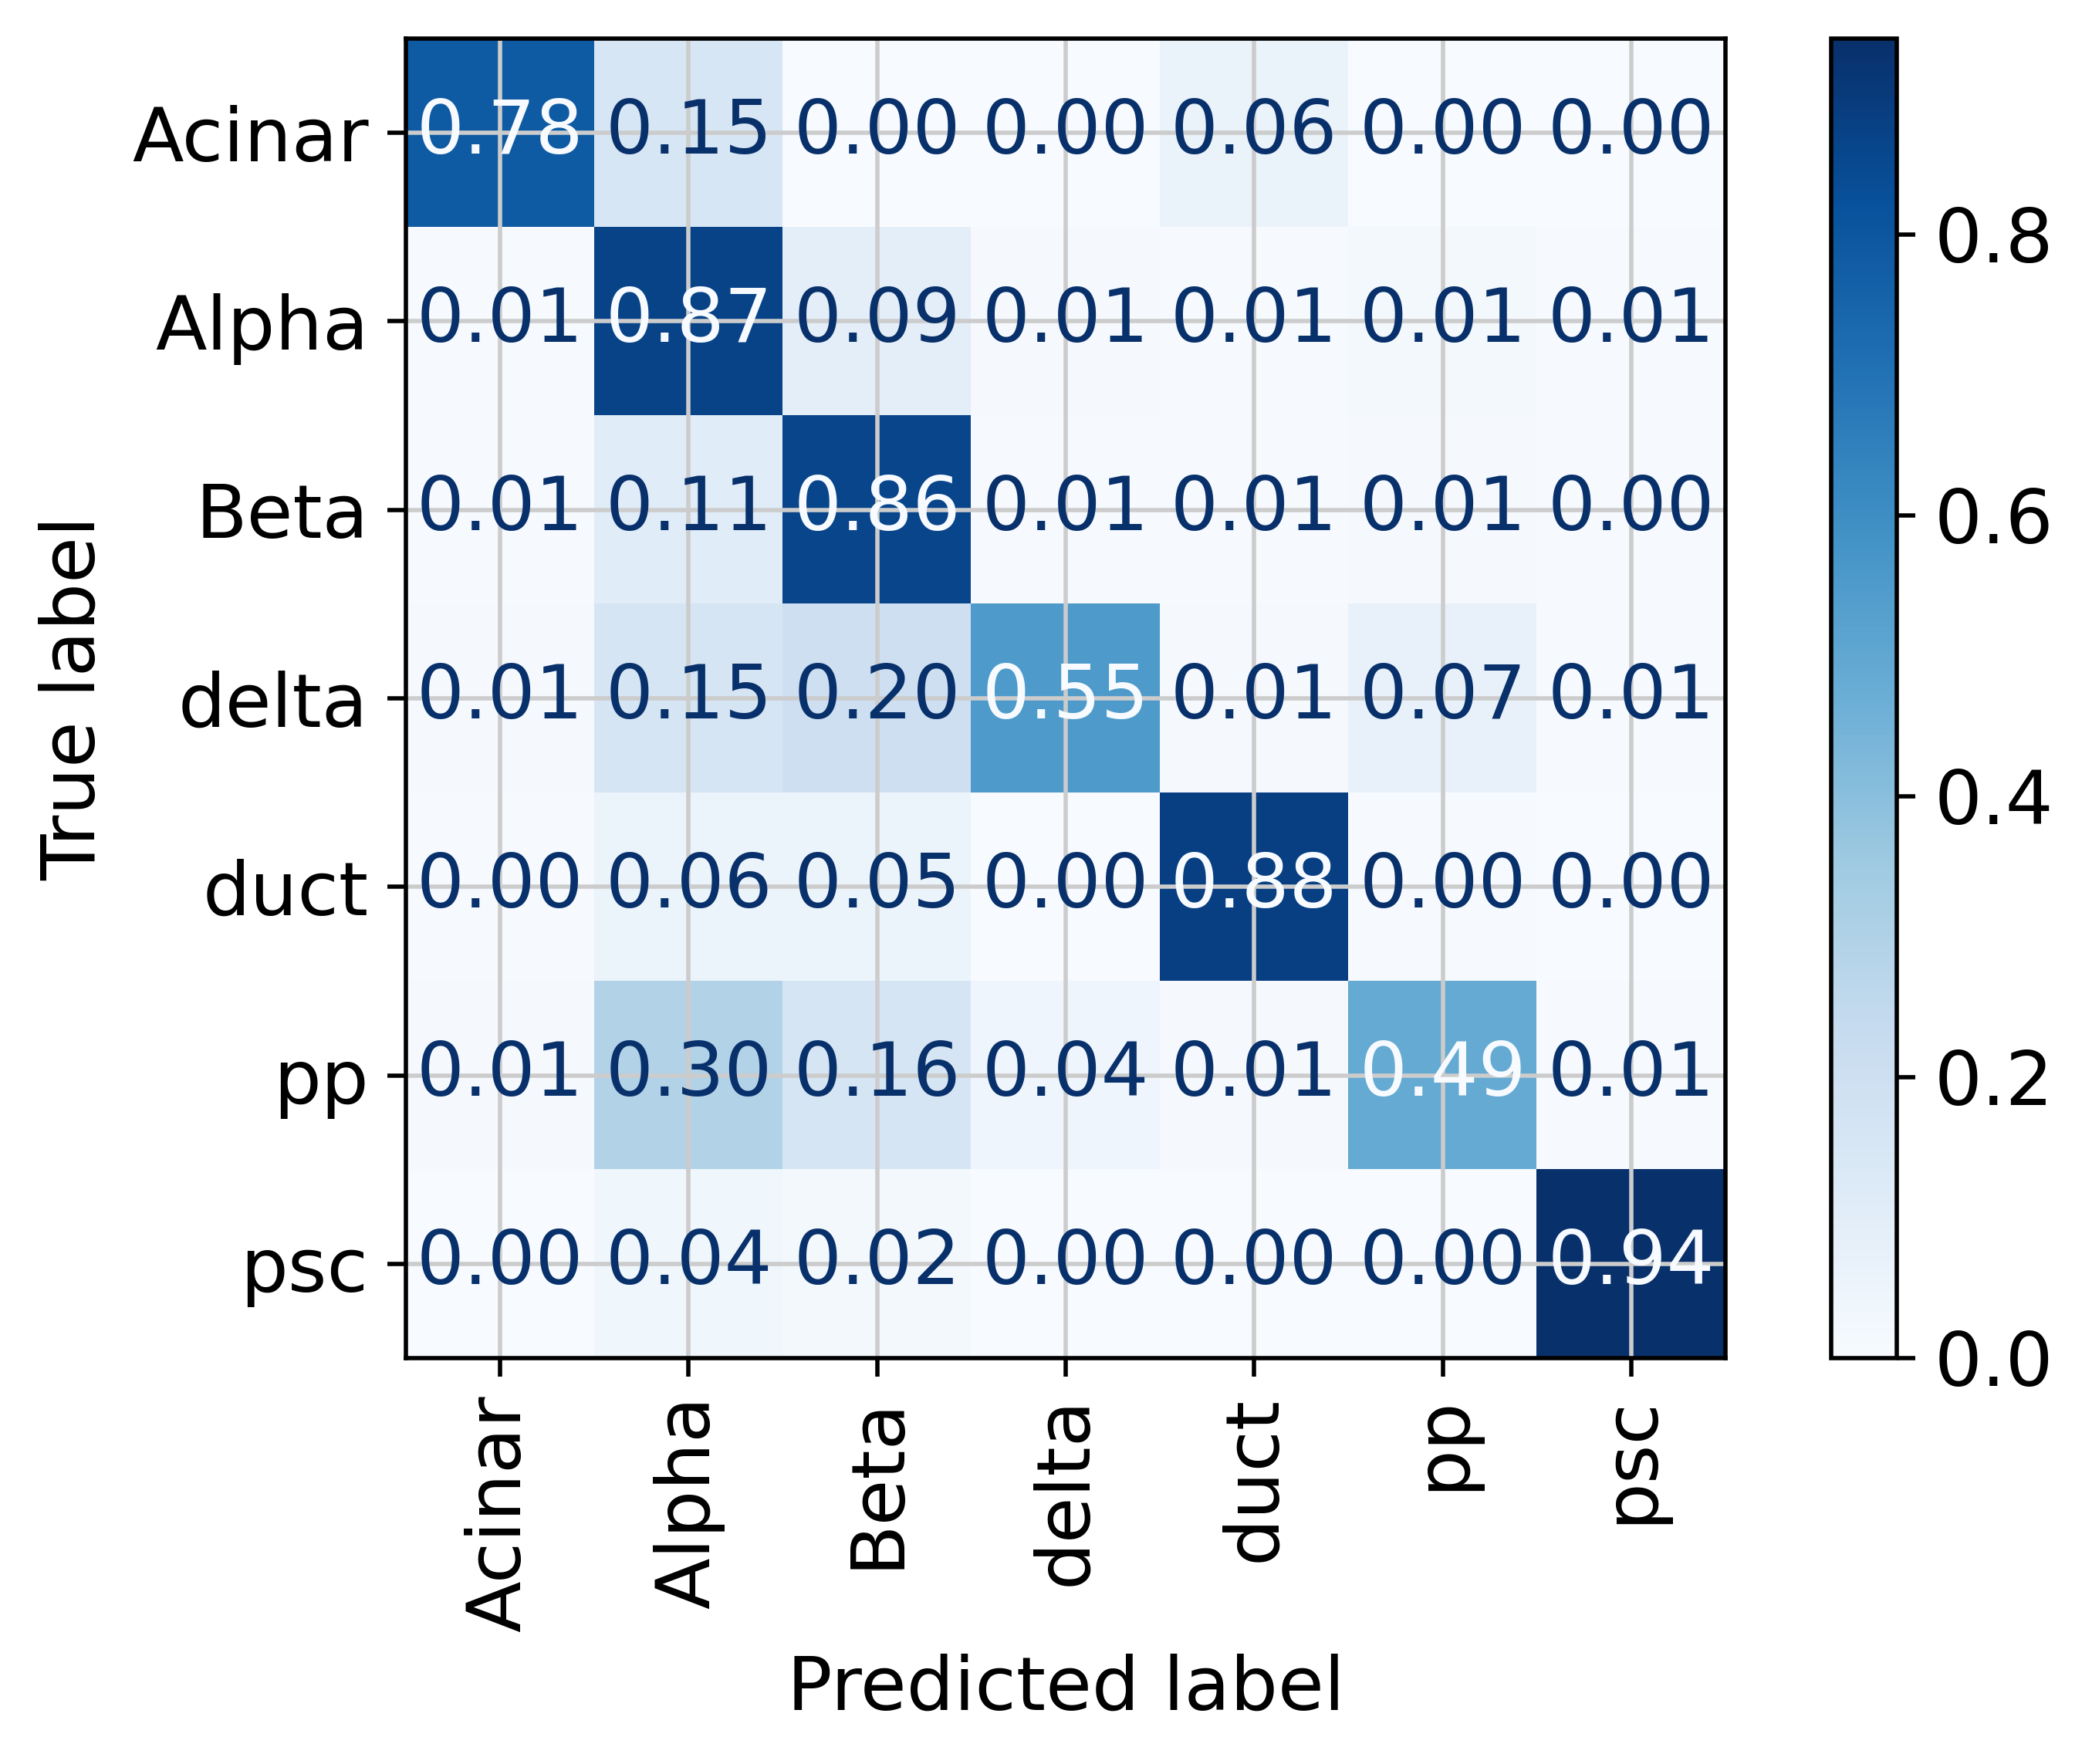

In [ ]:

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true1,
    y_pred=all_pred1,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical"
)

## Modelo 2: Treino D, Teste D

In [ ]:
dados2 = adata[adata.obs.Donor.isin(d)].copy()
dados2

AnnData object with n_obs × n_vars = 5617 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
Classifier2 = []
data2 = []

predicted2 = []
acc2 = []
f1_sep2 = []
f1_all2 = []

In [ ]:
for k in range(5):

  # Separação dos dados
  X_train2, X_test2, y_train2, y_test2 = train_test_split(dados2.X, dados2.obs.Celltype, test_size=0.2, random_state=k, stratify=dados2.obs.Celltype)
  data2.append((X_train2, X_test2, y_train2, y_test2))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in y_train2 if j==i]))
      test.append(len([j for j in y_test2 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Treinamento
  Classifier2.append(LinearSVC(max_iter=5000))
  Classifier2[-1].fit(X_train2, y_train2)

  # Teste
  predicted2.append(Classifier2[-1].predict(X_test2))

  ### Avaliação do modelo
  # Acurácia
  acc2.append(Classifier2[-1].score(X_test2, y_test2))
  # F1
  f1_sep2.append(metrics.f1_score(y_test2, predicted2[-1], average=None))
  f1_all2.append(metrics.f1_score(y_test2, predicted2[-1], average="macro"))


,Train,Test
Acinar,17,5
Alpha,2434,609
Beta,1444,361
delta,105,26
duct,272,68
pp,64,16
psc,157,39


In [ ]:
results2 = pd.DataFrame({"Acurácia": acc2, "F1_all": f1_all2}, index= ["Fold " + str(i+1) for i in range(5)])

for i in range(len(classes)):
  results2["F1_" + classes[i]] = [f1_sep2[x][i] for x in range(5)]

display(results2)

display(results2.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.861210,0.781951,0.888889,0.887428,0.825911,0.571429,0.933333,0.416667,0.950000
Fold 2,0.836299,0.713043,0.909091,0.870416,0.797814,0.300000,0.948148,0.230769,0.935065
Fold 3,0.825623,0.716652,0.888889,0.859438,0.771588,0.400000,0.962963,0.160000,0.973684
Fold 4,0.853203,0.768061,0.888889,0.881826,0.808163,0.550000,0.961832,0.285714,1.000000
Fold 5,0.847865,0.748742,1.000000,0.883031,0.805930,0.523810,0.919708,0.160000,0.948718


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.844840,0.745690,0.915152,0.876428,0.801881,0.469048,0.945197,0.250630,0.961493
std,0.014047,0.030552,0.048232,0.011386,0.019796,0.115519,0.018651,0.106796,0.025618
min,0.825623,0.713043,0.888889,0.859438,0.771588,0.300000,0.919708,0.160000,0.935065
25%,0.836299,0.716652,0.888889,0.870416,0.797814,0.400000,0.933333,0.160000,0.948718
50%,0.847865,0.748742,0.888889,0.881826,0.805930,0.523810,0.948148,0.230769,0.950000
75%,0.853203,0.768061,0.909091,0.883031,0.808163,0.550000,0.961832,0.285714,0.973684
max,0.861210,0.781951,1.000000,0.887428,0.825911,0.571429,0.962963,0.416667,1.000000


In [ ]:
all_pred2 = np.concatenate(predicted2).ravel()
all_true2 = np.concatenate([data2[i][3] for i in range(5)]).ravel()
mat2 = metrics.confusion_matrix(all_pred2, all_true2)

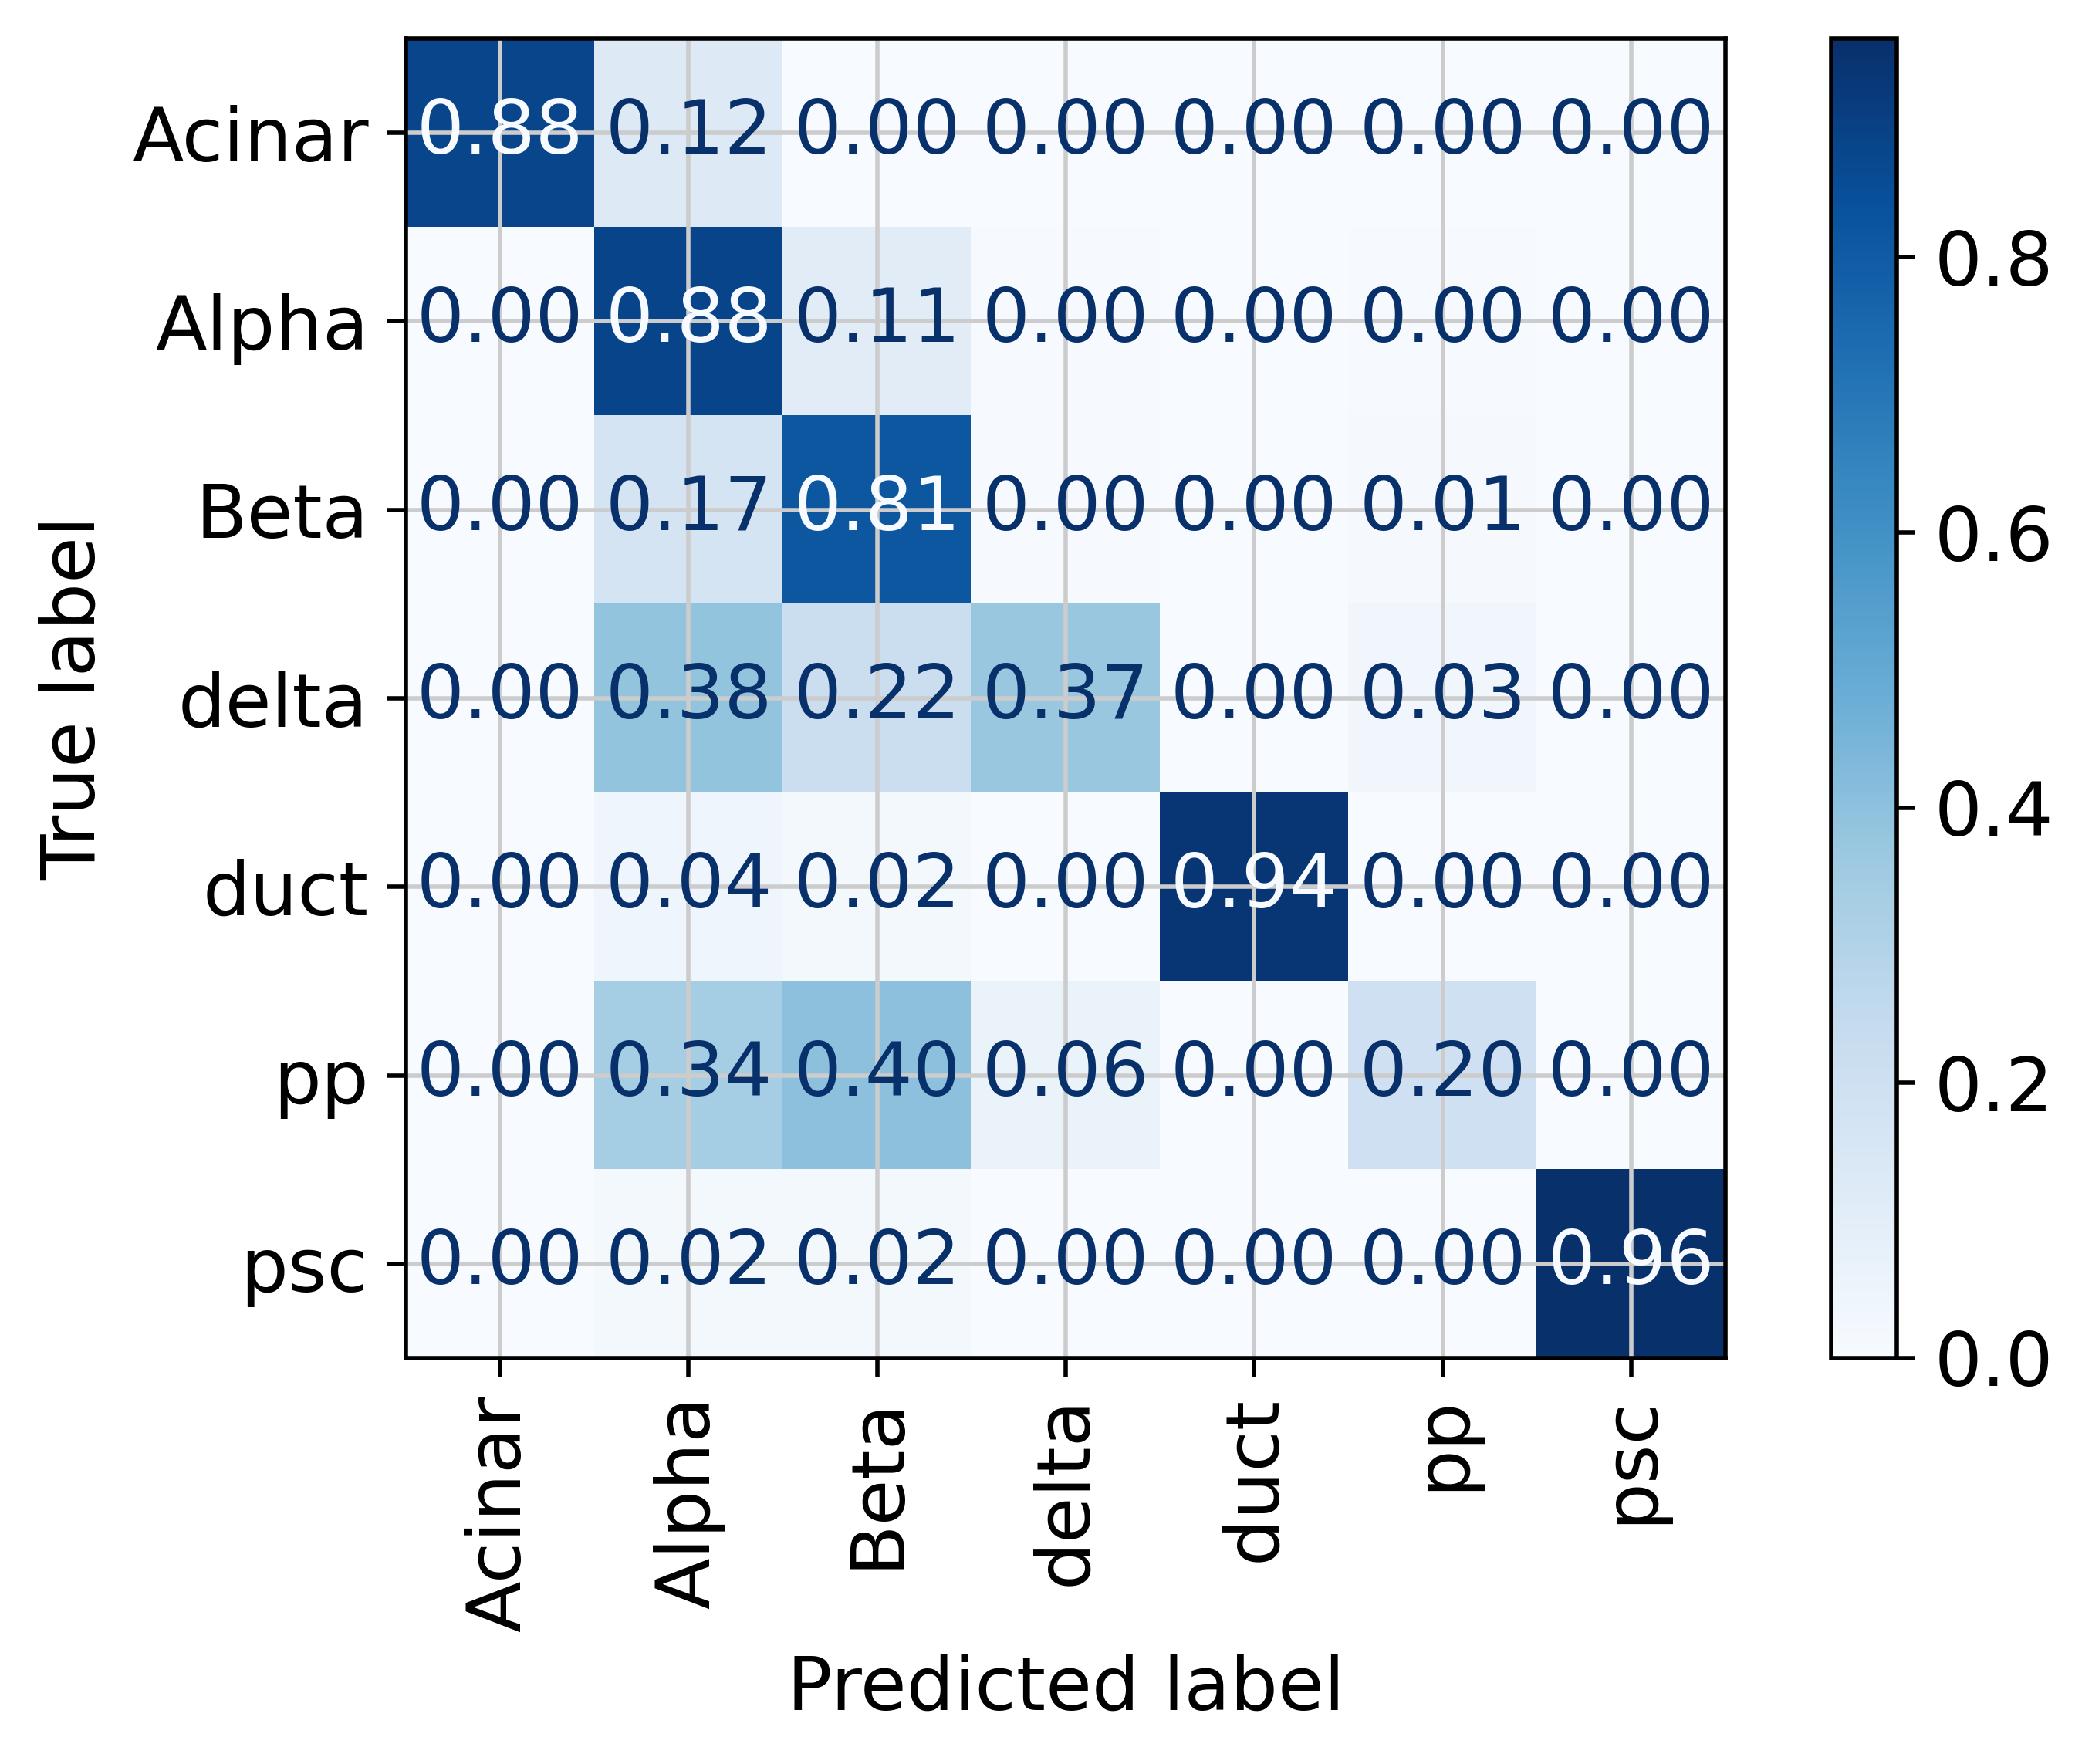

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true2,
    y_pred=all_pred2,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical"
)

## Modelo 3: Treino H, Teste D

In [ ]:
data3 = []

predicted3 = []
acc3 = []
f1_sep3 = []
f1_all3 = []

In [ ]:
for k in range(5):

  # Separação dos dados
  X_test3, _, y_test3, _ = train_test_split(dados2.X, dados2.obs.Celltype, test_size=0.2, random_state=k, stratify=dados2.obs.Celltype)
  data3.append((X_test3, y_test3))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in data1[k][2] if j==i]))
      test.append(len([j for j in y_test3 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Teste
  predicted3.append(Classifier1[k].predict(X_test3))

  ### Avaliação do modelo
  # Acurácia
  acc3.append(Classifier1[k].score(X_test3, y_test3))
  # F1
  f1_sep3.append(metrics.f1_score(y_test3, predicted3[-1], average=None))
  f1_all3.append(metrics.f1_score(y_test3, predicted3[-1], average="macro"))


,Train,Test
Acinar,54,17
Alpha,7748,2434
Beta,6245,1444
delta,389,105
duct,742,272
pp,450,64
psc,751,157


In [ ]:
results3 = pd.DataFrame({"Acurácia": acc3, "F1_all": f1_all3}, index= ["Fold " + str(i+1) for i in range(5)])

for i in range(len(classes)):
  results3["F1_" + classes[i]] = [f1_sep3[x][i] for x in range(5)]

display(results3)

display(results3.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.834632,0.697163,0.576923,0.869073,0.815140,0.445545,0.896811,0.361290,0.915361
Fold 2,0.836857,0.705085,0.640000,0.871104,0.816532,0.462366,0.894640,0.350649,0.900302
Fold 3,0.835299,0.682298,0.517241,0.871380,0.821157,0.464088,0.880150,0.358974,0.863095
Fold 4,0.835077,0.698552,0.561404,0.870149,0.817627,0.485437,0.881356,0.397351,0.876543
Fold 5,0.843757,0.717414,0.666667,0.879749,0.818989,0.507772,0.907104,0.350649,0.890966


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.837124,0.700102,0.592447,0.872291,0.817889,0.473041,0.892012,0.363783,0.889253
std,0.003801,0.012772,0.060478,0.004267,0.002311,0.024032,0.011313,0.019372,0.020325
min,0.834632,0.682298,0.517241,0.869073,0.815140,0.445545,0.880150,0.350649,0.863095
25%,0.835077,0.697163,0.561404,0.870149,0.816532,0.462366,0.881356,0.350649,0.876543
50%,0.835299,0.698552,0.576923,0.871104,0.817627,0.464088,0.894640,0.358974,0.890966
75%,0.836857,0.705085,0.640000,0.871380,0.818989,0.485437,0.896811,0.361290,0.900302
max,0.843757,0.717414,0.666667,0.879749,0.821157,0.507772,0.907104,0.397351,0.915361


In [ ]:
all_pred3 = np.concatenate(predicted3).ravel()
all_true3 = np.concatenate([data3[i][1] for i in range(5)]).ravel()
mat3 = metrics.confusion_matrix(all_pred3, all_true3)

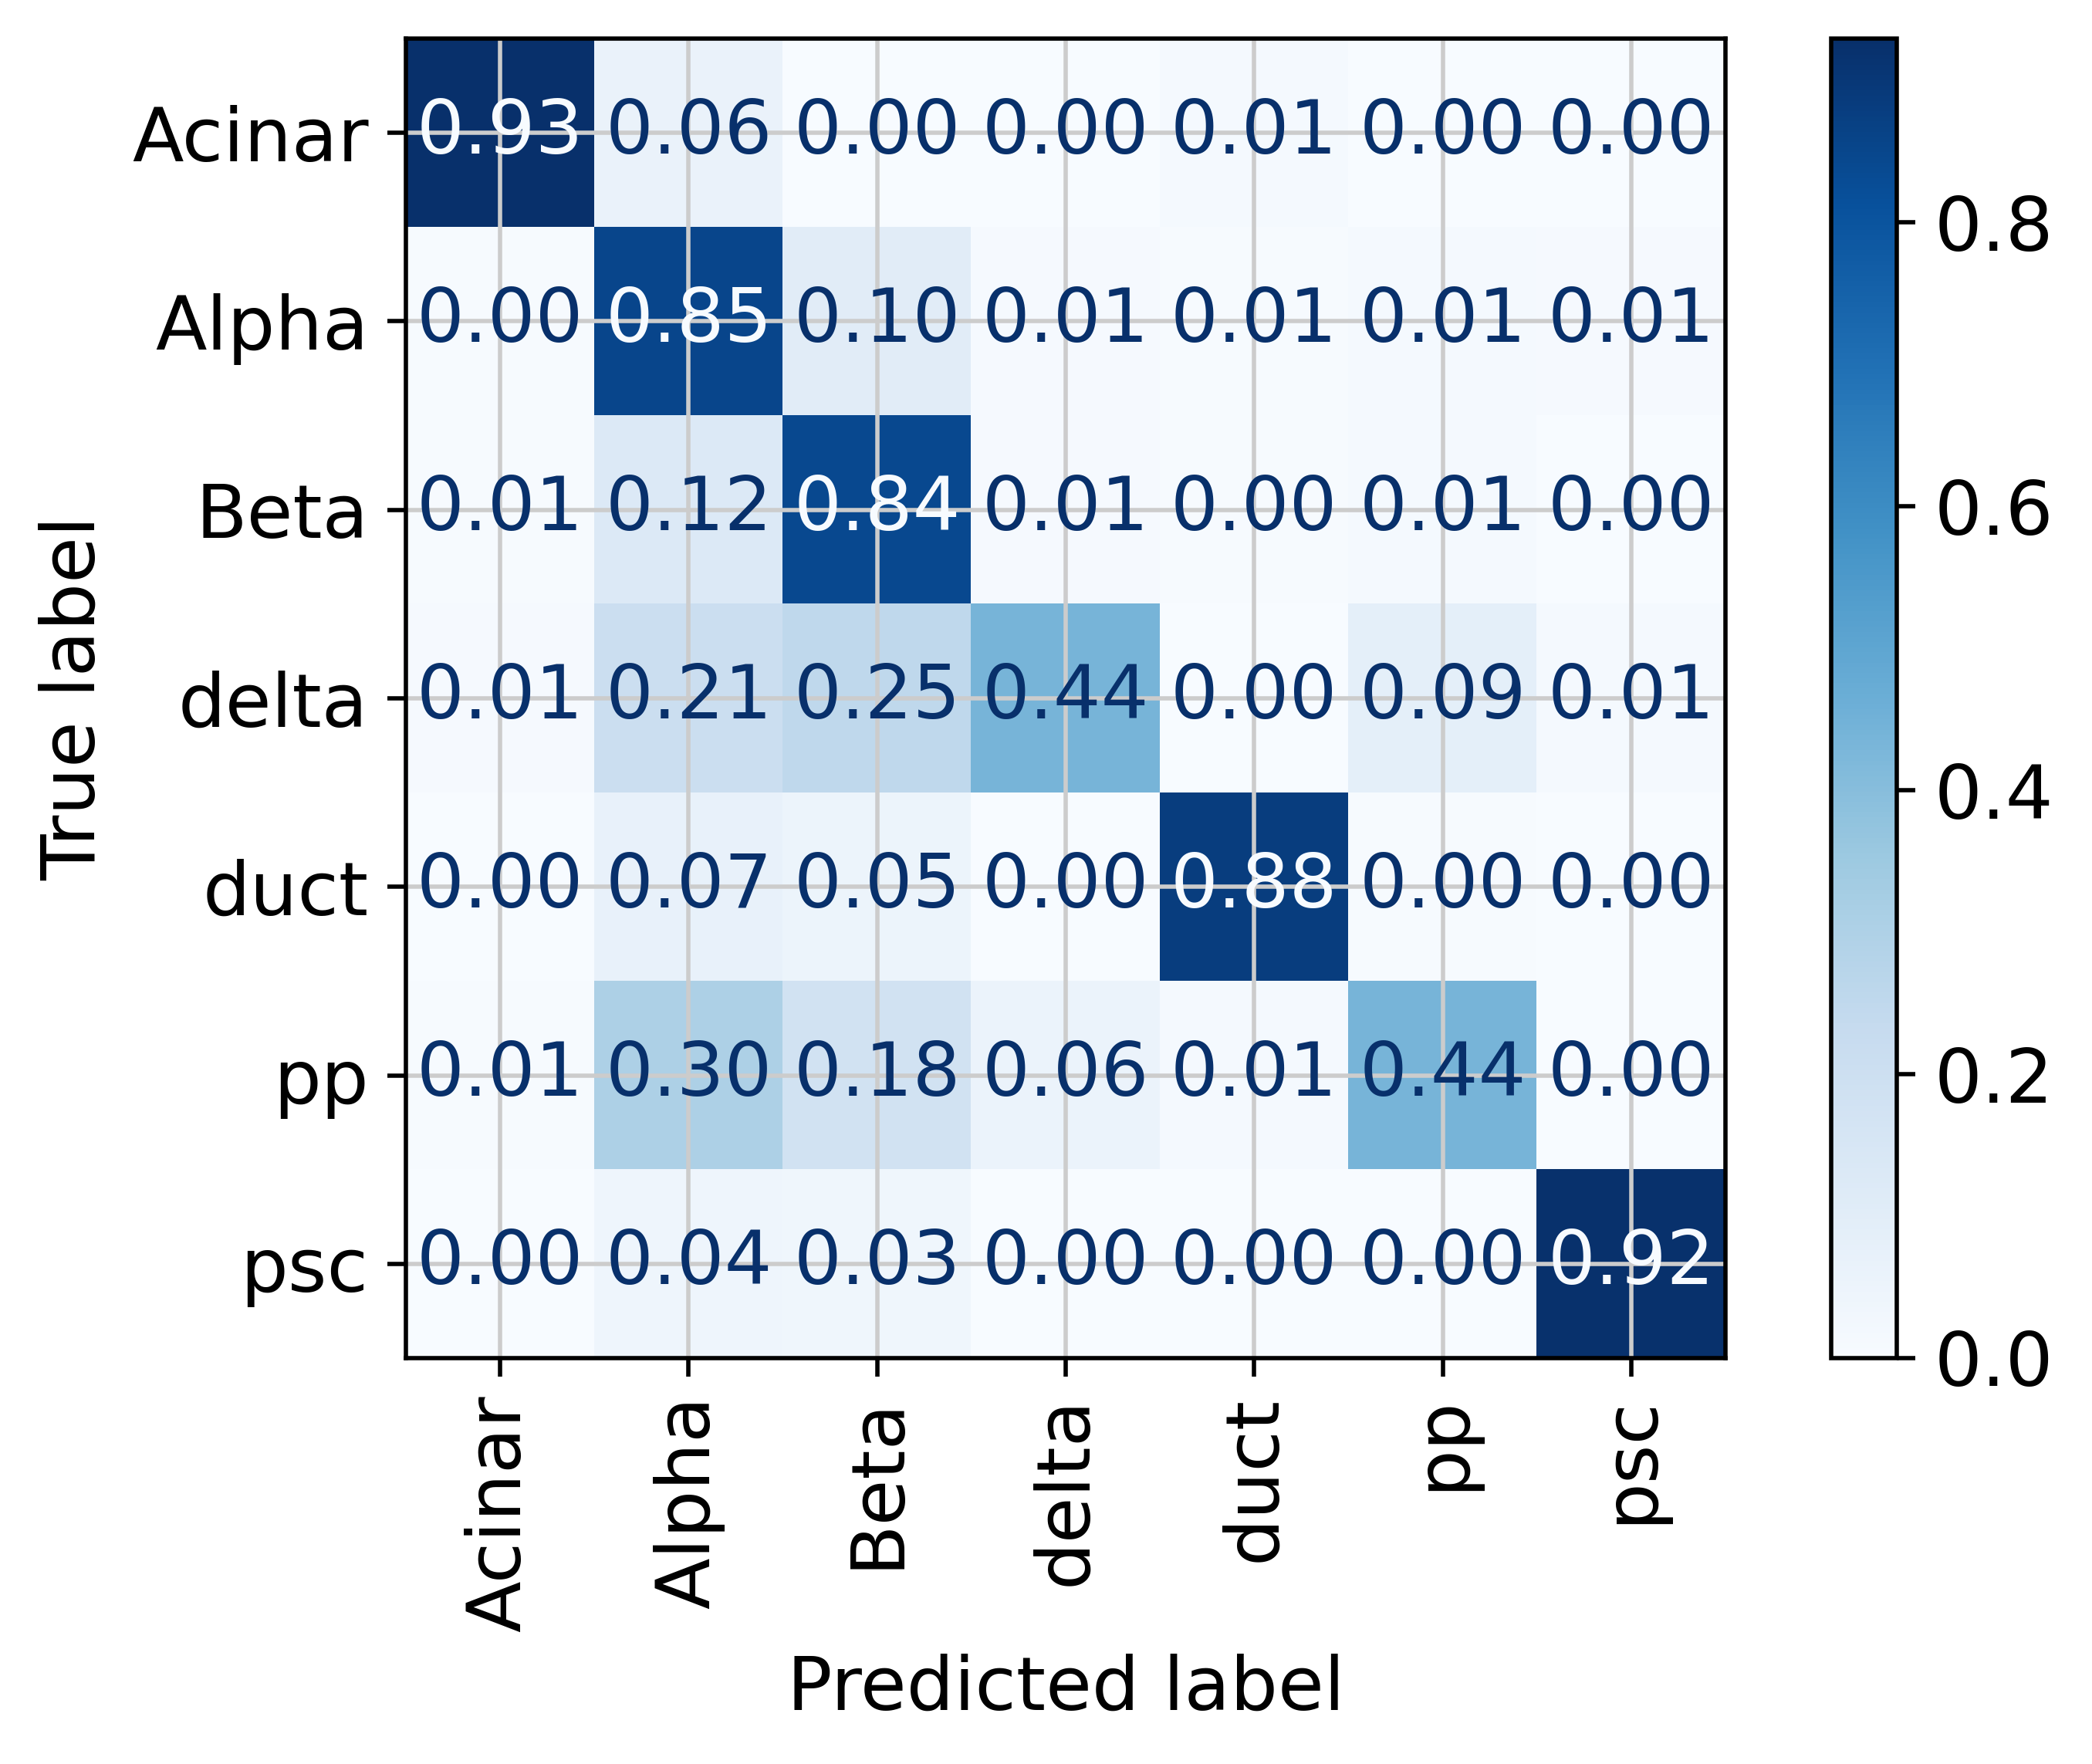

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true3,
    y_pred=all_pred3,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical"
)

## Salvar os resultados

In [ ]:
results1.to_csv("./SVM_metricas1.csv")
results2.to_csv("./SVM_metricas2.csv")
results3.to_csv("./SVM_metricas3.csv")